In [20]:
import math
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras.applications import EfficientNetB0, InceptionV3
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras import Model
from tensorflow.keras.optimizers import SGD

In [10]:
num_classes = 211
dropout_rate = 0.2
img_size = 224
base_lr = 0.01
momentum = 0
batch_size = 32
epochs = 10

### Data pipeline

In [36]:
dataset_path = '/ssd/fagner/datasets/iwildcam2020/resized_cropped/'
metadata_file = '/data/fagner/iWildCam2020/repositories/iwildcam2020/data/iwildcam211_metadata.csv'

In [37]:
iwild211 = pd.read_csv(metadata_file, index_col='id')

In [38]:
def read_decode_image(image_path, label):
    image = tf.io.read_file(dataset_path + image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.cast(image, tf.float32) / 255.
    label = tf.one_hot(label, num_classes)
    
    return image, label

In [39]:
def generate_dataset(filenames, labels, training=True):
    AUTOTUNE = tf.data.experimental.AUTOTUNE
    dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))
    dataset = dataset.repeat(epochs)
    
    if(training):
        dataset = dataset.shuffle(len(filenames))
    
    dataset = dataset.map(read_decode_image, num_parallel_calls=AUTOTUNE)
    
#     if(training):
#         dataset = dataset.map(apply_augmentation, num_parallel_calls=AUTOTUNE)
#     else:
#         dataset = dataset.map(resize_image, num_parallel_calls=AUTOTUNE)
    
#     dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
#     dataset = dataset.prefetch(buffer_size=AUTOTUNE)
    
    return dataset

In [40]:
iwild211_train_df = iwild211[iwild211['spliting'] == 'train'].copy()
iwild211_train = generate_dataset(iwild211_train_df.image_id.values,
                                  iwild211_train_df.name_coded.values, 
                                  training=True)

In [115]:
image, label = next(iter(iwild211_train))

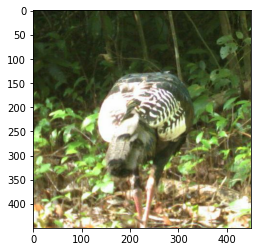

In [116]:
plt.imshow(image)

### Training Procedure

In [3]:
scaled_lr = base_lr * batch_size / 256

In [4]:
def lr_cosine_decay(initial_learning_rate, current_step, decay_steps, alpha=0.0):
    
    if current_step > decay_steps:
        current_step = decay_steps
    
    cosine_decay = 0.5 * (1 + tf.math.cos(math.pi * current_step / float(decay_steps)))
    decayed = (1 - alpha) * cosine_decay + alpha
    
    return initial_learning_rate * decayed

def lr_linear_warmup(initial_learning_rate, current_step, warmup_steps):
    
    return current_step * initial_learning_rate / float(warmup_steps)


class CosineDecayWithLinearWarmUpScheduler(keras.callbacks.Callback):
    
    def __init__(self, initial_learning_rate, decay_steps, warmup_steps=0, alpha=0.0):
        super(CosineDecayWithWarmUp, self).__init__()
        self.initial_learning_rate = initial_learning_rate
        self.decay_steps = decay_steps
        self.warmup_steps = warmup_steps
        self.alpha = alpha
        self.steps = 0
        self.learning_rates = []
    
    def on_train_batch_begin(self, batch, logs=None):
        if not hasattr(self.model.optimizer, "lr"):
            raise ValueError('Optimizer must have a "lr" attribute.')

        self.steps = self.steps + 1
        
        if self.steps < self.warmup_steps:
            lr = lr_linear_warmup(
                    self.initial_learning_rate,
                    self.steps,
                    self.warmup_steps)
        else:            
            lr = lr_cosine_decay(
                    self.initial_learning_rate,
                    self.steps - self.warmup_steps,
                    self.decay_steps,
                    alpha)
        
        tf.keras.backend.set_value(self.model.optimizer.lr, lr)
        
        self.learning_rates.append(lr)

In [5]:
base_model = EfficientNetB0(
    include_top=False,
    weights="imagenet",
    input_shape=(img_size,img_size,3)
)
x = GlobalAveragePooling2D()(base_model.output)
x = Dropout(rate=dropout_rate)(x)
output = Dense(num_classes, activation='softmax')(x)
model = Model(inputs=[base_model.input], outputs=[output])

In [6]:
optimizer = SGD(lr=scaled_lr, momentum=momentum)

In [7]:
model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy', 'top_k_categorical_accuracy'])